#### **Importing Libraries**

In [1]:
import os
import pandas as pd
import seaborn as sns

from googleapiclient.discovery import build

#### **Setting up YouTube API.**

In [2]:
api_service_name = "youtube"
api_version = "v3"

yt_api_key = os.environ["YT_API_KEY"]

### **I. Scraping Channel Statistics.**

#### Getting Channel ID's.

In [3]:
channel_ids = [
    "UCX6OQ3DkcsbYNE6H8uQQuVA",
    "UC59ZRYCHev_IqjUhremZ8Tg",
    "UCvgfXK4nTYKudb0rFR6noLA",
    "UCc0YbtMkRdhcqwhu3Oad-lw",
]

#### Building YouTube API Service.

In [4]:
youtube = build(api_service_name, api_version, developerKey=yt_api_key)  

#### Function to obtain channel statistics.

In [5]:
def get_channel_statistics(youtube, channel_ids):
    data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics", id=",".join(channel_ids)
    )

    response = request.execute()

    for i in range(len(response["items"])):
        info = dict(
            channel_name=response["items"][i]["snippet"]["title"],
            subscribers=response["items"][i]["statistics"]["subscriberCount"],
            videos=response["items"][i]["statistics"]["videoCount"],
            views=response["items"][i]["statistics"]["viewCount"],
            # --------
            playlist_id=response["items"][i]["contentDetails"]["relatedPlaylists"]['uploads'],
        )

        data.append(info)

    return data

In [6]:
channel_statistics = get_channel_statistics(youtube, channel_ids)

#### Create a dataframe. 

In [7]:
channel_df = pd.DataFrame(channel_statistics)
channel_df

,channel_name,subscribers,videos,views,playlist_id
0,UFC,17500000,15926,7784942599,UUvgfXK4nTYKudb0rFR6noLA
1,Harry Mack,2640000,498,231600882,UU59ZRYCHev_IqjUhremZ8Tg
2,Breaking Bad & Better Call Saul,746000,773,593154876,UUc0YbtMkRdhcqwhu3Oad-lw
3,MrBeast,233000000,774,41694966373,UUX6OQ3DkcsbYNE6H8uQQuVA


#### Change datatype from object to integer.

In [8]:
channel_df.dtypes

channel_name    object
subscribers     object
videos          object
views           object
playlist_id     object
dtype: object

In [9]:
exclude_cols = ['channel_name']

cols_to_include = [col for col in channel_df.columns if col not in exclude_cols]

In [10]:
channel_df[cols_to_include] = channel_df[cols_to_include].applymap(pd.to_numeric, errors='coerce')

In [11]:
channel_df.dtypes

channel_name     object
subscribers       int64
videos            int64
views             int64
playlist_id     float64
dtype: object

### **II. Scraping Video Details.**

#### Function to get video ID's.

In [12]:
def get_video_ids(youtube, playlist_id):
    video_ids = []

    request = youtube.playlistItems().list(
        part="contentDetails", playlistId=playlist_id, maxResults=50
    )

    response = request.execute()

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get("nextPageToken")

    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token,
        )

        response = request.execute()

        for i in range(len(response['items'])):
            video_ids.append(response['items'][i]['contentDetails']['videoId'])

        next_page_token = response.get("nextPageToken")

    return video_ids

In [13]:
# Breaking Bad & Better call Saul.
playlist_id = "UUc0YbtMkRdhcqwhu3Oad-lw"

In [14]:
video_ids = get_video_ids(youtube, playlist_id)

In [15]:
len(video_ids)

774

#### Function to get video details.

In [16]:
def get_video_details(youtube, video_ids):
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics", 
            id=",".join(video_ids[i : i + 50])
        )

        response = request.execute()

        for video in response["items"]:
            stats_to_keep = {
                "snippet": [
                    "channelTitle",
                    "title",
                    "description",
                    "tags",
                    "publishedAt",
                ],

                "statistics": [
                    "viewCount",
                    "likeCount",
                    "favouriteCount",
                    "commentCount",
                ],

                "contentDetails": [
                    "duration", 
                    "definition", 
                    "caption"],
            }

            video_info = {}
            video_info["video_id"] = video["id"]


            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)


    return pd.DataFrame(all_video_info)

In [17]:
video_details = get_video_details(youtube, video_ids)

In [18]:
video_details.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [19]:
video_details["viewCount"] = video_details["viewCount"].apply(pd.to_numeric, errors="coerce")

Getting the top 8 videos by view count.

In [20]:
video_details.sort_values(by="viewCount", ascending=False).head(8)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
542,MybaTnzu9AA,Breaking Bad & Better Call Saul,The Death Of Gustavo Fring | Face Off | Breaki...,"After their plan to kill Gus fails, Walt (Brya...","[Breaking Bad, Walter White, Bryan Cranston, N...",2019-07-08T14:57:13Z,21820541,362645,None,18503,PT2M48S,hd,false
303,74qGp120JK8,Breaking Bad & Better Call Saul,When You Make Yourself At Home... | #Shorts | ...,Watch Now!: https://play.google.com/store/tv/s...,"[Breaking Bad, Walter White, Bryan Cranston, A...",2022-05-23T15:30:04Z,18931740,725463,None,2588,PT55S,hd,false
238,XQQI72wQjEA,Breaking Bad & Better Call Saul,Every Time Mike Outsmarted His Enemies | Break...,They always think they can get him...\n\nWatch...,"[Breaking Bad, Walter White, Bryan Cranston, A...",2022-09-27T15:00:32Z,11230934,113317,None,3680,PT20M31S,hd,false
332,9TohDsmT8tA,Breaking Bad & Better Call Saul,Walter White Kills Mike Ehrmantraut | Say My N...,Walter White and Mike Ehrmantraut meet up and ...,"[Breaking Bad, Walter White, Bryan Cranston, A...",2022-03-01T16:30:02Z,10364122,129583,None,11366,PT5M19S,hd,false
341,N723si1wAG8,Breaking Bad & Better Call Saul,"""Come On, Take My Gun From Me"" | Pimento | Bet...",Sobchak mocks Mike for not carrying a gun for ...,"[Breaking Bad, Walter White, Bryan Cranston, A...",2022-02-01T16:30:06Z,10000894,118231,None,7257,PT4M12S,hd,false
558,4kyxZI1UCKM,Breaking Bad & Better Call Saul,"""You're Lucky He Hasn't Fired Your Ass"" | Salu...",As Walt (Bryan Cranston) is recovering from th...,"[Breaking Bad, Walter White, Bryan Cranston, N...",2019-04-25T18:56:38Z,9604803,146976,None,6662,PT3M3S,hd,false
565,ZeVWpQUfmag,Breaking Bad & Better Call Saul,Gus' Close Encounter With Hector & Don Eladio ...,As Hank (Dean Norris) produces evidence that G...,"[Breaking Bad, Walter White, Bryan Cranston, N...",2019-04-06T19:00:19Z,8838825,87759,None,8829,PT2M54S,hd,false
652,rArzMrhTxF8,Breaking Bad & Better Call Saul,Saul Gets The Better Of Jesse's Parents | I.F....,As he finds Skyler is dead set on getting a di...,"[Breaking Bad, Walter White, Bryan Cranston, N...",2018-08-13T21:44:41Z,8789096,114066,None,6885,PT3M1S,hd,false


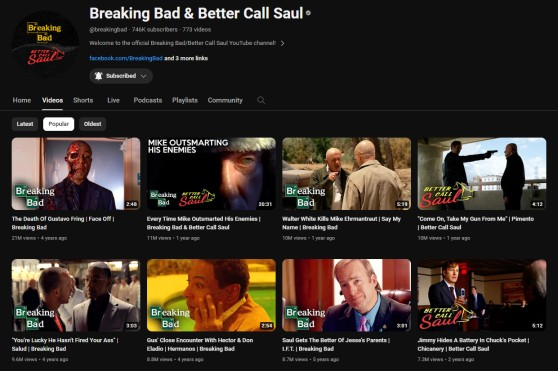